In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import trans_forms
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision.models import resnet18, resnet34
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import xml.etree.ElementTree as ET
from tqdm import tqdm


VOC_CLASSES = {
    'background': 0,
    'aeroplane': 1, 'bicycle': 2, 'bird': 3, 'boat': 4, 'bottle': 5,
    'bus': 6, 'car': 7, 'cat': 8, 'chair': 9, 'cow': 10, 'diningtable': 11,
    'dog': 12, 'horse': 13, 'motorbike': 14, 'person': 15, 'pottedplant': 16,
    'sheep': 17, 'sofa': 18, 'train': 19, 'tvmonitor': 20
}

class VOCSegmentationDataset(Dataset):
    def __init__(self, root, image_set='train', year='2012', trans_form=None, target_trans_form=None):
        self.root = os.path.join(root, f'VOC{year}')
        self.image_set = image_set
        self.trans_form = trans_form
        self.target_trans_form = target_trans_form

    
        self.image_dir = os.path.join(self.root, 'JPEGImages')
        self.mask_dir = os.path.join(self.root, 'SegmentationClass')

        image_set_path = os.path.join(self.root, 'ImageSets', 'Segmentation', f'{image_set}.txt')
        with open(image_set_path) as f:
            self.image_ids = f.read().strip().split()

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]


        image_path = os.path.join(self.image_dir, f'{image_id}.jpg')
        image = Image.open(image_path).convert('RGB')

        mask_path = os.path.join(self.mask_dir, f'{image_id}.png')
        mask = Image.open(mask_path)
        
        if self.trans_form:
            image = self.trans_form(image)
        if self.target_trans_form:
            mask = self.target_trans_form(mask)

        return image, mask


device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")


trans_form = trans_forms.Compose([
    trans_forms.Resize((384, 384)),  
    trans_forms.ToTensor(),
    trans_forms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

target_trans_form = trans_forms.Compose([
    trans_forms.Resize((384, 384), interpolation=trans_forms.InterpolationMode.NEAREST),
    trans_forms.ToTensor()
])


dataset = VOCSegmentationDataset(
    root='/Users/jithinrajan/Desktop/VOCdevkit', 
    image_set='train',
    trans_form=trans_form,
    target_trans_form=target_trans_form
)


total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

training_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
value_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0)

Using device: mps


In [2]:

model = deeplabv3_resnet50(pretrained=True)
model.classifier[-1] = nn.Conv2d(256, len(VOC_CLASSES), kernel_size=1) 
model = model.to(device)


criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def calculate_miou(pred, target, num_classes=21):
    ious = []
    pred = pred.flatten()
    target = target.flatten()
    
    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append(intersection / union)
    
    return np.nanmean(ious)

def visualize_segmentation(image, mask, pred_mask, title):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))
    
 
    img_display = image.cpu().permute(1, 2, 0).numpy()
    img_display = (img_display * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]).clip(0, 1)
    ax1.imshow(img_display)
    ax1.set_title('Original Image')
    ax1.axis('off')
   
    ax2.imshow(mask.squeeze().cpu().numpy())
    ax2.set_title('Ground Truth')
    ax2.axis('off')
    
    
    pred_mask_np = pred_mask.squeeze().cpu().numpy()
    contours, _ = cv2.findContours(pred_mask_np.astype(np.uint8), 
                                 cv2.RETR_EXTERNAL, 
                                 cv2.CHAIN_APPROX_SIMPLE)
    
    ax3.imshow(pred_mask_np)
    for contour in contours:
        ax3.plot(contour[:, 0, 0], contour[:, 0, 1], 'r', linewidth=1)
    ax3.set_title('Prediction with Contours')
    ax3.axis('off')
    
    plt.suptitle(title)
    plt.show()

/Users/jithinrajan/opt/anaconda3/envs/torch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/jithinrajan/opt/anaconda3/envs/torch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/293 [00:00<?, ?it/s]

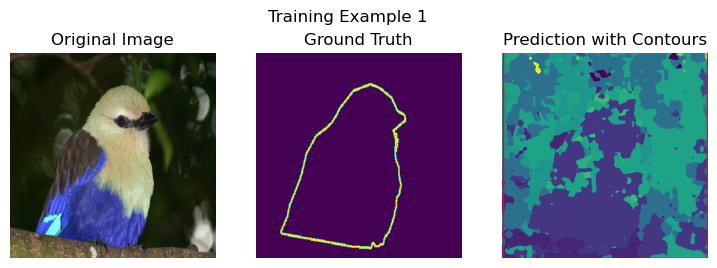

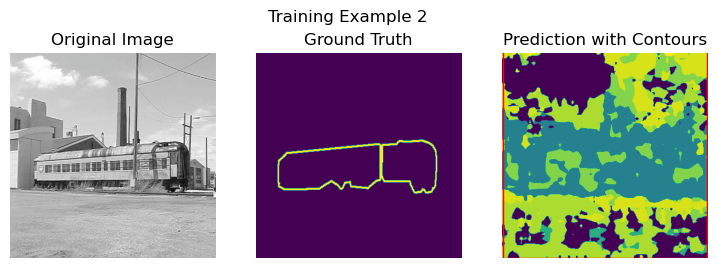

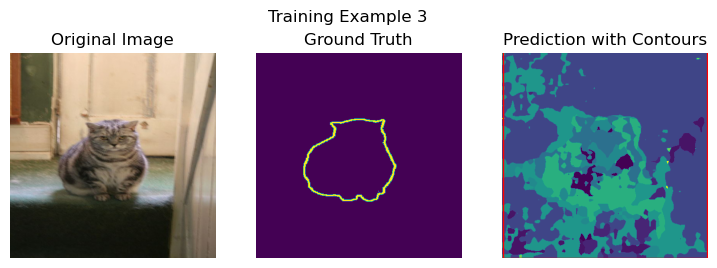

100%|██████████| 293/293 [15:10<00:00,  3.11s/it]


Epoch 1/10:
Average Train Loss: 1.3640
Average Train MIoU: 0.2714
Validation MIoU: 0.4777


100%|██████████| 293/293 [16:00<00:00,  3.28s/it]


Epoch 2/10:
Average Train Loss: 0.3251
Average Train MIoU: 0.4916
Validation MIoU: 0.4785


  0%|          | 0/293 [00:00<?, ?it/s]

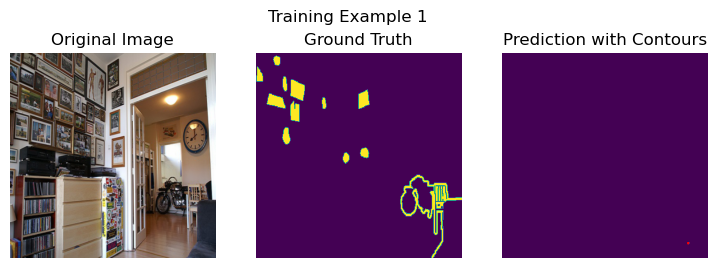

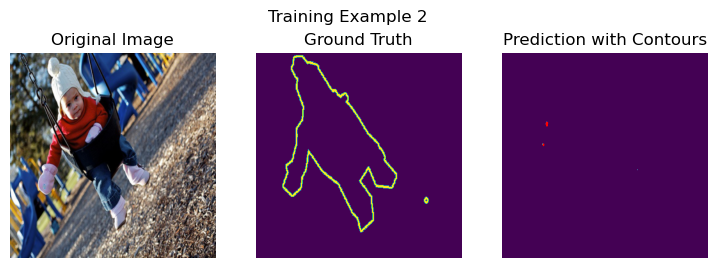

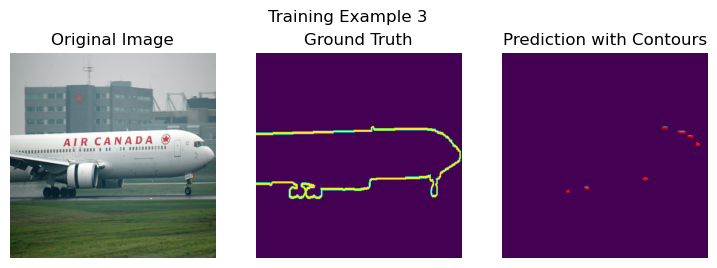

100%|██████████| 293/293 [17:52<00:00,  3.66s/it]


Epoch 3/10:
Average Train Loss: 0.2024
Average Train MIoU: 0.5028
Validation MIoU: 0.4896


100%|██████████| 293/293 [14:34<00:00,  2.99s/it]


Epoch 4/10:
Average Train Loss: 0.1707
Average Train MIoU: 0.5164
Validation MIoU: 0.5152


  0%|          | 0/293 [00:00<?, ?it/s]

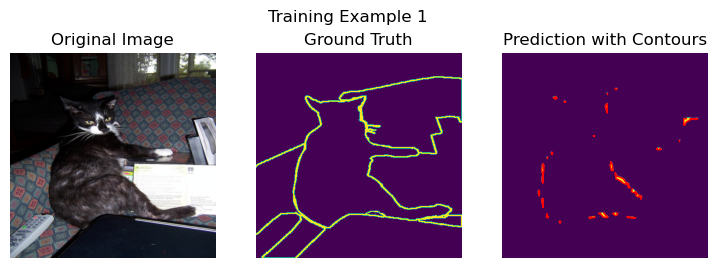

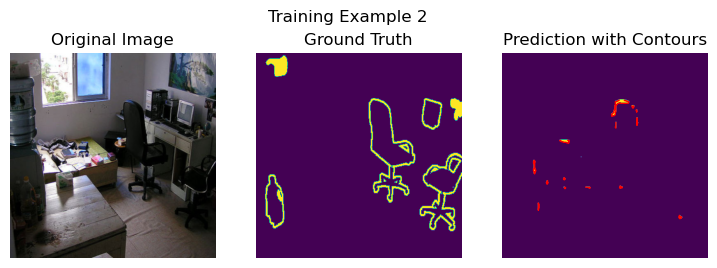

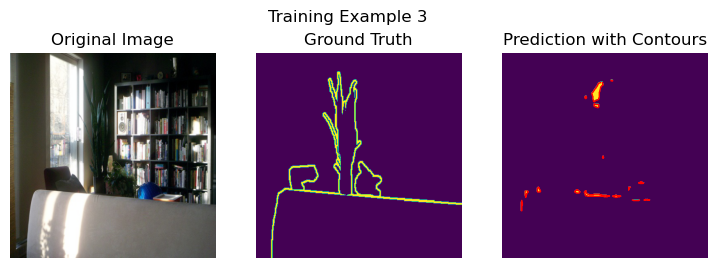

100%|██████████| 293/293 [15:09<00:00,  3.10s/it]


Epoch 5/10:
Average Train Loss: 0.1505
Average Train MIoU: 0.5381
Validation MIoU: 0.5021


100%|██████████| 293/293 [14:58<00:00,  3.07s/it]


Epoch 6/10:
Average Train Loss: 0.1382
Average Train MIoU: 0.5531
Validation MIoU: 0.5329


  0%|          | 0/293 [00:00<?, ?it/s]

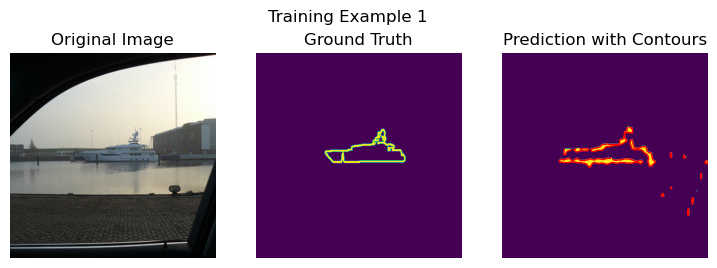

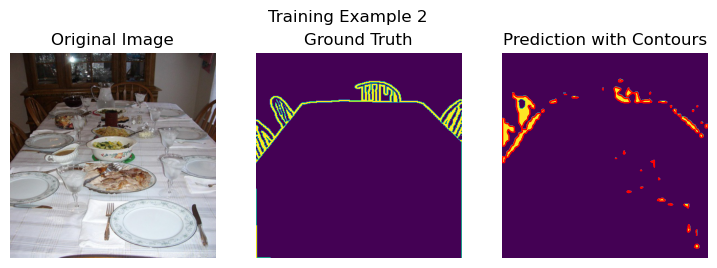

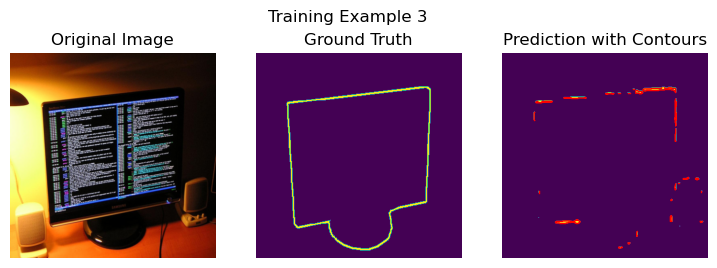

100%|██████████| 293/293 [13:41<00:00,  2.80s/it]


Epoch 7/10:
Average Train Loss: 0.1249
Average Train MIoU: 0.5849
Validation MIoU: 0.5054


100%|██████████| 293/293 [13:37<00:00,  2.79s/it]


Epoch 8/10:
Average Train Loss: 0.1142
Average Train MIoU: 0.6054
Validation MIoU: 0.4963


  0%|          | 0/293 [00:00<?, ?it/s]

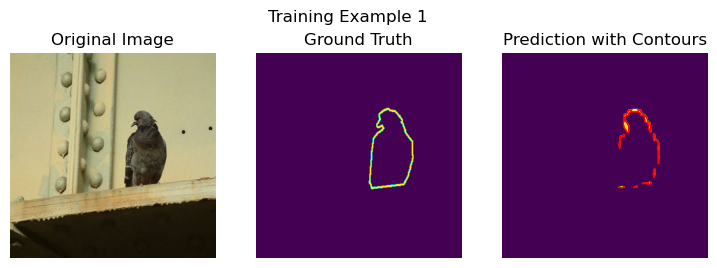

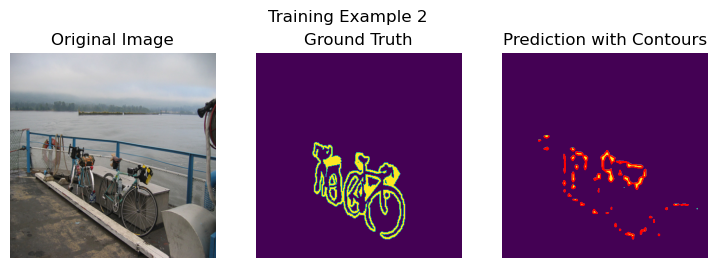

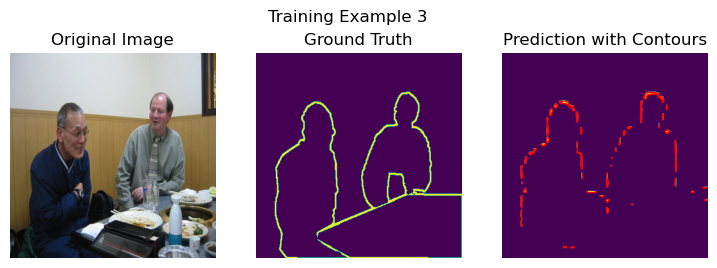

100%|██████████| 293/293 [13:37<00:00,  2.79s/it]


Epoch 9/10:
Average Train Loss: 0.1130
Average Train MIoU: 0.6007
Validation MIoU: 0.5377


100%|██████████| 293/293 [13:53<00:00,  2.84s/it]


Epoch 10/10:
Average Train Loss: 0.1017
Average Train MIoU: 0.6280
Validation MIoU: 0.5447


In [3]:

num_epochs = 10
best_miou = 0.0
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_miou = 0
    
    for batch_idx, (images, masks) in enumerate(tqdm(training_loader)):
        images = images.to(device)
        masks = masks.squeeze(1).long().to(device)
        
        optimizer.zero_grad()
        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        pred_masks = torch.argmax(outputs, dim=1)
        batch_miou = calculate_miou(pred_masks.cpu(), masks.cpu())
        train_miou += batch_miou
        
       
        if epoch%2 == 0 and batch_idx == 0:
            for i in range(min(3, images.size(0))):
                visualize_segmentation(
                    images[i],
                    masks[i],
                    pred_masks[i],
                    f'Training Example {i+1}'
                )
    
    avg_train_loss = train_loss / len(training_loader)
    avg_train_miou = train_miou / len(training_loader)
    
  
    model.eval()
    val_miou = 0
    
    with torch.no_grad():
        for images, masks in value_loader:
            images = images.to(device)
            masks = masks.squeeze(1).long().to(device)
            outputs = model(images)['out']
            pred_masks = torch.argmax(outputs, dim=1)
            val_miou += calculate_miou(pred_masks.cpu(), masks.cpu())
    
    avg_val_miou = val_miou / len(value_loader)
    
    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Average Train Loss: {avg_train_loss:.4f}')
    print(f'Average Train MIoU: {avg_train_miou:.4f}')
    print(f'Validation MIoU: {avg_val_miou:.4f}')
    
   
    if avg_val_miou > best_miou:
        best_miou = avg_val_miou
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_miou': best_miou,
        }, 'best_model.pth')

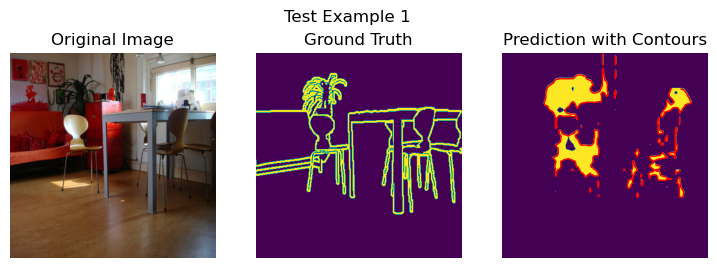

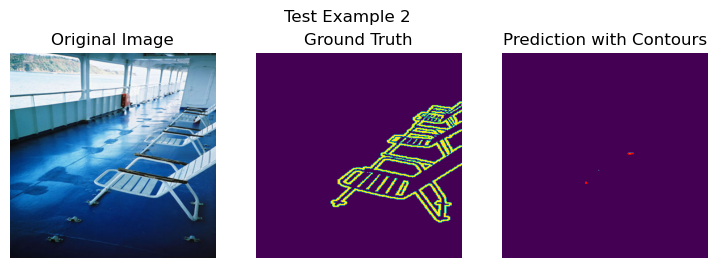

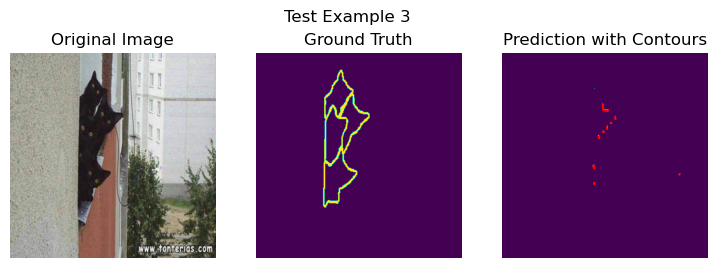

Test MIoU: 0.5586


In [4]:

checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
test_miou = 0

with torch.no_grad():
    for batch_idx, (images, masks) in enumerate(test_loader):
        images = images.to(device)
        masks = masks.squeeze(1).long().to(device)
        outputs = model(images)['out']
        pred_masks = torch.argmax(outputs, dim=1)
        test_miou += calculate_miou(pred_masks.cpu(), masks.cpu())
        
        if batch_idx == 0:
            for i in range(min(3, images.size(0))):
                visualize_segmentation(
                    images[i],
                    masks[i],
                    pred_masks[i],
                    f'Test Example {i+1}'
                )

avg_test_miou = test_miou / len(test_loader)
print(f'Test MIoU: {avg_test_miou:.4f}')